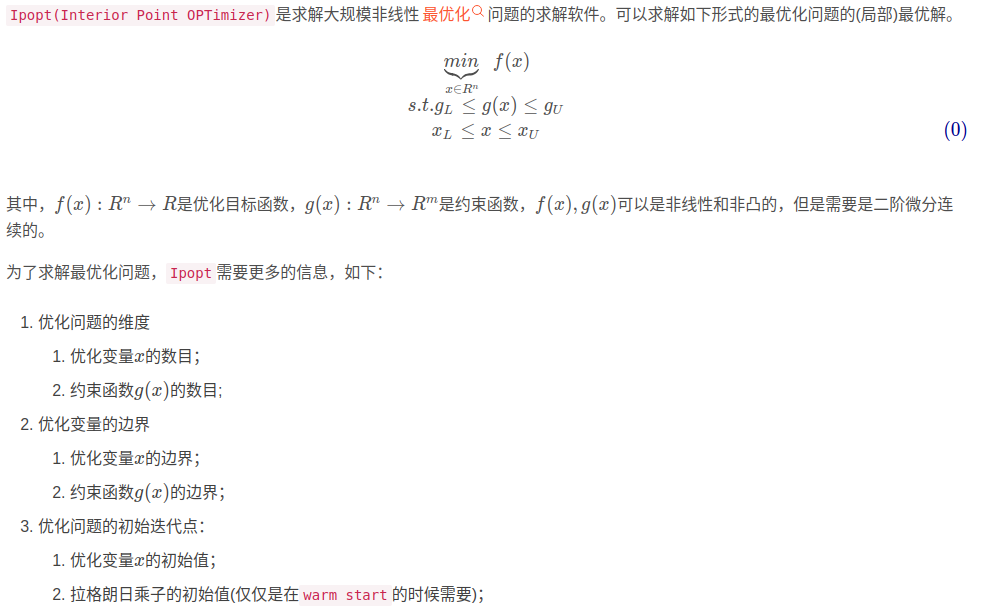

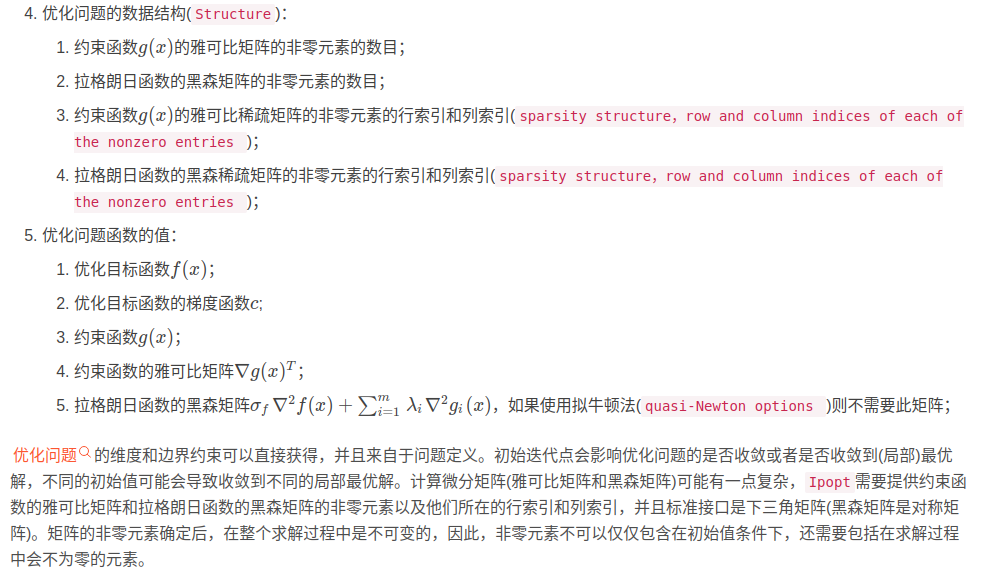

In [ ]:
template <class Dvector, class FG_eval>
void solve(
    const std::string&                   options   ,
    const Dvector&                       xi        ,
    const Dvector&                       xl        ,
    const Dvector&                       xu        ,
    const Dvector&                       gl        ,
    const Dvector&                       gu        ,
    FG_eval&                             fg_eval   ,
    ipopt::solve_result<Dvector>&        solution  )

  调用IPOPT求解器求解优化问题
  参数说明：
  - options: 求解器选项
  - xi: 初始点
  - xl, xu: 变量边界
  - gl, gu: 约束边界  
  - fg_eval: 目标函数和约束评估对象
  - solution: 求解结果

In [ ]:
// 设置IPOPT求解器的选项
std::string options;
/* 设置options */

// 定义双精度向量类型
typedef CPPAD_TESTVECTOR(double) Dvector;  
/* 定义 x0, xl, xu, gl, gu*/

// 声明求解结果对象
CppAD::ipopt::solve_result<Dvector> solution;

// 调用IPOPT求解器求解优化问题
CppAD::ipopt::solve<Dvector, FG_eval>(options, x0, xl, xu, gl, gu, fg_eval, solution);

常用选项表：

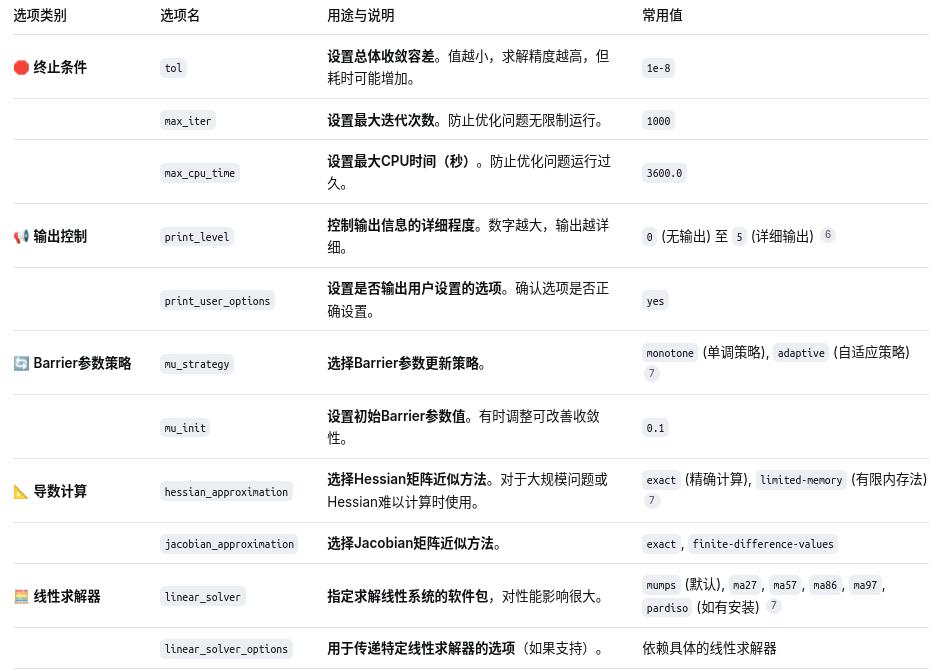

In [ ]:
// 选择自适应的Barrier参数更新策略[citation:7]
options += "String  mu_strategy adaptive\n"; 
// 使用有限内存法近似Hessian矩阵[citation:7]
options += "String  hessian_approximation limited-memory\n"; 
// 指定使用MUMPS线性求解器[citation:7]
options += "linear_solver mumps\n";  
// 关闭输出打印 (0=无输出, 5=详细输出)
options += "Integer print_level  0\n";
// 隐藏求解器横幅
options += "String sb            yes\n";
// 设置最大迭代次数
options += "Integer max_iter     10\n";
// 设置收敛容差
options += "Numeric tol          1e-6\n";
// 设置导数检验方式（二阶导数检验）
options += "String derivative_test   second-order\n";
// 设置扰动半径为0（不使用随机扰动）
options += "Numeric point_perturbation_radius   0.\n";

对于目标函数和约束评估对象  
必须包含以下的结构，一个字都不能错  

    typedef CPPAD_TESTVECTOR(CppAD::AD<double>) ADvector;

    void operator()(ADvector& fg, const ADvector& x);

fg: 输出向量，存储目标函数和约束值  
x: 输入向量，存储优化变量  
必须使用 AD\<double\> 类型（自动微分类型）  

In [ ]:
// 定义目标函数和约束条件的类
class FG_eval
{
public:
  // 必须定义AD（自动微分）向量类型
  typedef CPPAD_TESTVECTOR(CppAD::AD<double>) ADvector;
  // 重载()运算符，定义优化问题的目标函数和约束条件
  void operator()(ADvector& fg, const ADvector& x);

  
  // 可选: 可以添加构造函数传递额外参数
  FG_eval(const std::vector<double>& params) {
  // 用于传递问题参数
  }
private:
  // 可选: 可以添加成员变量存储问题数据
  // std::vector<double> problem_parameters;
};

对于void operator()(ADvector& fg, const ADvector& x)需要定义以下内容：

In [ ]:
void operator()(ADvector& fg, const ADvector& x)
{
    // fg 的大小 = 1 + 约束个数
    // x 的大小 = 优化变量个数

    assert(fg.size() == 1 + number_of_constraints);
    assert(x.size() == number_of_variables);

    // 使用 AD<double> 类型
    AD<double> x1 = x[0];
    
    // fg[0] 必须存储目标函数值
    fg[0] = ...; // 目标函数

    // fg[1], fg[2], ... 存储约束函数值
    fg[1] = ...; // 第一个约束
    fg[2] = ...; // 第二个约束
    // ...
}

CppAD 中的初等函数使用要求

在 FG_eval 类的 operator() 成员函数中，所有数学运算都应使用CppAD命名空间下的相应函数，或者使用已由CppAD为 AD<Base> 类型重载的运算符。

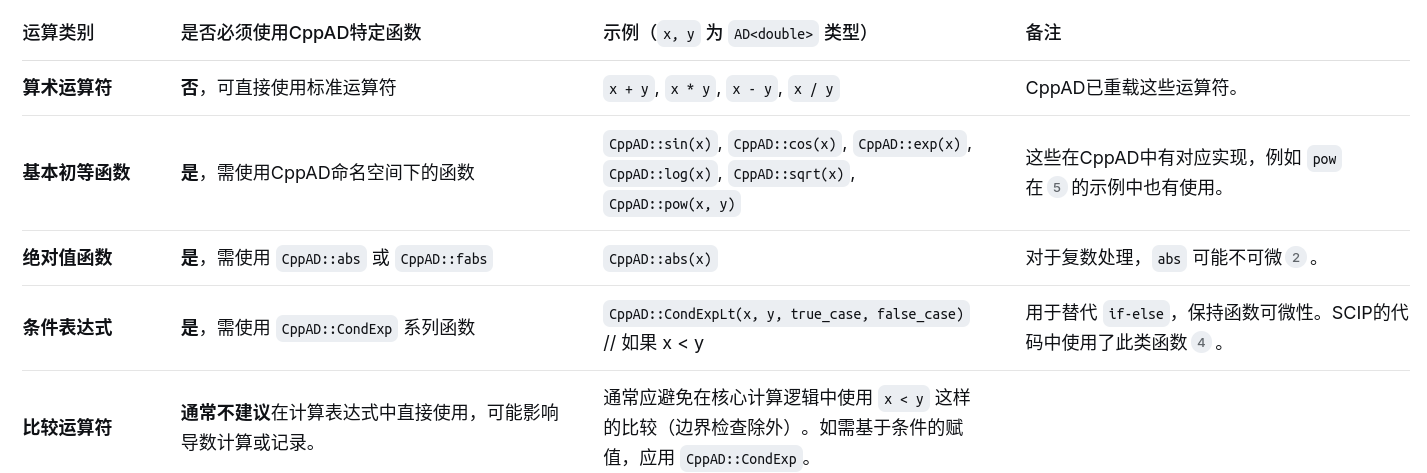

问题描述

求解以下非线性优化问题：

$minimize: x1*x4*(x1+x2+x3) + x3  $  
约束条件:  
    不等式  
    $x1*x2*x3*x4 ≥ 25 $   
    等式  
    $x1² + x2² + x3² + x4² = 40  $  
    决策变量约束  
    $1.0 ≤ x1,x2,x3,x4 ≤ 5.0  $  

初始点: (1.0, 5.0, 5.0, 1.0)  

In [ ]:
  typedef CPPAD_TESTVECTOR(double) Dvector;  // 定义双精度向量类型

  // 问题规模定义
  size_t nx = 4;   // 优化变量的个数
  size_t ng = 2;   // 约束条件的个数
  
  // 设置初始点
  Dvector x0(nx);
  x0[0] = 1.0;  // x1初始值
  x0[1] = 5.0;  // x2初始值  
  x0[2] = 5.0;  // x3初始值
  x0[3] = 1.0;  // x4初始值

  // 设置变量的下界和上界 [1.0, 5.0]
  Dvector xl(nx), xu(nx);
  for (i = 0; i < nx; i++)
  {
    xl[i] = 1.0;  // 所有变量的下界
    xu[i] = 5.0;  // 所有变量的上界
  }

In [ ]:
  // 设置约束条件的下界和上界
  Dvector gl(ng), gu(ng);
  // 第一个约束: x1*x2*x3*x4 ≥ 25 (不等式约束)
  gl[0] = 25.0;      // 下界
  gu[0] = 1.0e19;    // 上界设为很大的数，表示只有下界约束
  
  // 第二个约束: x1² + x2² + x3² + x4² = 40 (等式约束)
  gl[1] = 40.0;      // 下界
  gu[1] = 40.0;      // 上界等于下界，表示等式约束

In [ ]:
using CppAD::AD;
void FG_eval::operator()(ADvector& fg, const ADvector& x)
{
    assert(fg.size() == 3);  // fg[0]是目标函数，fg[1-2]是约束条件
    assert(x.size() == 4);   // 有4个优化变量

    // 提取优化变量
    AD<double> x1 = x[0];
    AD<double> x2 = x[1];
    AD<double> x3 = x[2];
    AD<double> x4 = x[3];

    // fg[0] = 目标函数: x1*x4*(x1+x2+x3) + x3
    fg[0] = x1 * x4 * (x1 + x2 + x3) + x3;

    // fg[1] = 第一个约束条件: x1*x2*x3*x4 (不等式约束)
    fg[1] = x1 * x2 * x3 * x4;

    // fg[2] = 第二个约束条件: x1² + x2² + x3² + x4² (等式约束)
    fg[2] = x1 * x1 + x2 * x2 + x3 * x3 + x4 * x4;

    return;
}

后处理，最后进行结果查看及一些状态查看，主要来自于solution

In [ ]:
template <class Dvector>
class solve_result
{
public:
    /// 求解器返回状态的可能值
    enum status_type {
        not_defined,           ///< 状态尚未定义（初始状态）
        success,               ///< 成功：在满足收敛容差的点终止
        maxiter_exceeded,      ///< 超过最大迭代次数
        stop_at_tiny_step,     ///< 步长过小而停止
        stop_at_acceptable_point, ///< 在可接受点停止（未达到期望容差但达到可接受容差）
        local_infeasibility,   ///< 收敛到不可行点（问题可能无解）
        user_requested_stop,   ///< 用户请求停止（通常不会出现）
        feasible_point_found,  ///< 找到可行点（特定情况下使用）
        diverging_iterates,    ///< 迭代点发散
        restoration_failure,   ///< 恢复阶段失败，算法无法继续
        error_in_step_computation, ///< 步长计算中发生不可恢复错误
        invalid_number_detected,  ///< 检测到无效数值（NaN或Inf）
        too_few_degrees_of_freedom, ///< 自由度不足
        internal_error,        ///< Ipopt内部错误
        unknown               ///< 未知状态
    };

    /// 求解状态
    status_type status;
    
    /// 近似最优解 - 决策变量的最优值
    /// 向量大小为优化变量的个数 nx
    /// 例如：如果问题是 min f(x1,x2)，那么 x = [x1*, x2*]
    Dvector x;
    
    /// 对应于变量下界约束的拉格朗日乘子
    /// 向量大小与 x 相同，每个元素表示对应变量下界约束的乘子
    /// 在最优解处，这些乘子表示下界约束的敏感度
    Dvector zl;
    
    /// 对应于变量上界约束的拉格朗日乘子  
    /// 向量大小与 x 相同，每个元素表示对应变量上界约束的乘子
    /// 在最优解处，这些乘子表示上界约束的敏感度
    Dvector zu;
    
    /// 约束函数在最优解 x 处的值
    /// 向量大小为约束的个数 ng
    /// 对于不等式约束 gL ≤ g(x) ≤ gU，这个向量包含实际的 g(x*) 值
    Dvector g;
    
    /// 对应于一般约束 g(x) 的拉格朗日乘子
    /// 向量大小与 g 相同，每个元素表示对应约束的乘子
    /// 在KKT条件下，这些乘子表示约束的敏感度
    Dvector lambda;
    
    /// 目标函数在最优解 x 处的值
    /// 标量值，表示找到的最优目标函数值 f(x*)
    double obj_value;
    
    /// 构造函数：初始化求解状态为未定义
    /// 在创建 solve_result 对象时自动调用，将所有状态设置为初始值
    solve_result(void)
    {   status = not_defined; }
};